# Exploratory Data Analysis (EDA): U.S. Oil & Gas (ONRR)

This notebook explores the **cleaned ONRR oil & gas dataset** to surface trends and business-relevant insights.  
We focus on volumes over time, by commodity, by geography, and by disposition.

> **Input:** `../data/cleaned/us_oil_gas_cleaned.csv`  
> **Output (optional):** figures saved under `../figures/`

---


In [11]:
## 3.1 Load Cleaned Data
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 5)

# Paths
CLEANED = "../data/cleaned/us_oil_gas_cleaned.csv"
FIG_DIR = "../figures"
os.makedirs(FIG_DIR, exist_ok=True)

# Load
df = pd.read_csv(CLEANED, parse_dates=['production_date'])
print("Loaded:", CLEANED, "| shape:", df.shape)
df.head()


Loaded: ../data/cleaned/us_oil_gas_cleaned.csv | shape: (470830, 13)


,production_date,land_class,land_category,state,county,fips_code,offshore_region,commodity,disposition_code,disposition_description,volume,year,month
0,2015-01-01,Federal,Offshore,Withheld,Withheld,NaN,Offshore Alaska,Gas (Mcf),1,Sales-Royalty Due-Measured,0,2015,1
1,2015-01-01,Federal,Offshore,Withheld,Withheld,NaN,Offshore Gulf,Gas (Mcf),1,Sales-Royalty Due-Measured,14508756,2015,1
2,2015-01-01,Federal,Offshore,Withheld,Withheld,NaN,Offshore Pacific,Gas (Mcf),1,Sales-Royalty Due-Measured,1207520,2015,1
3,2015-01-01,Federal,Offshore,Withheld,Withheld,NaN,Offshore Gulf,Gas (Mcf),4,Sales-Royalty Due-Not Measured,487324,2015,1
4,2015-01-01,Federal,Offshore,Withheld,Withheld,NaN,Offshore Pacific,Gas (Mcf),4,Sales-Royalty Due-Not Measured,114808,2015,1


## 3.2 Dataset Overview

In [12]:
# Schema / dtypes
df.dtypes

# Missing values (top 10)
df.isna().sum().sort_values(ascending=False).head(10)

# Basic stats for numeric columns
df.describe(include=[np.number]).T

,count,mean,std,min,25%,50%,75%,max
fips_code,454200.0,33246.875359,1.647127e+04,1003.0,22027.0,35045.0,48225.0,56045.0
disposition_code,470830.0,18.445779,1.421068e+01,1.0,10.0,17.0,25.0,69.0
volume,470830.0,132570.798568,1.840172e+06,-25877925.0,0.0,0.0,160.0,83628039.0
year,470830.0,2019.656568,3.021743e+00,2015.0,2017.0,2020.0,2022.0,2025.0
month,470830.0,6.358155,3.461143e+00,1.0,3.0,6.0,9.0,12.0


## 3.3 Univariate Distributions

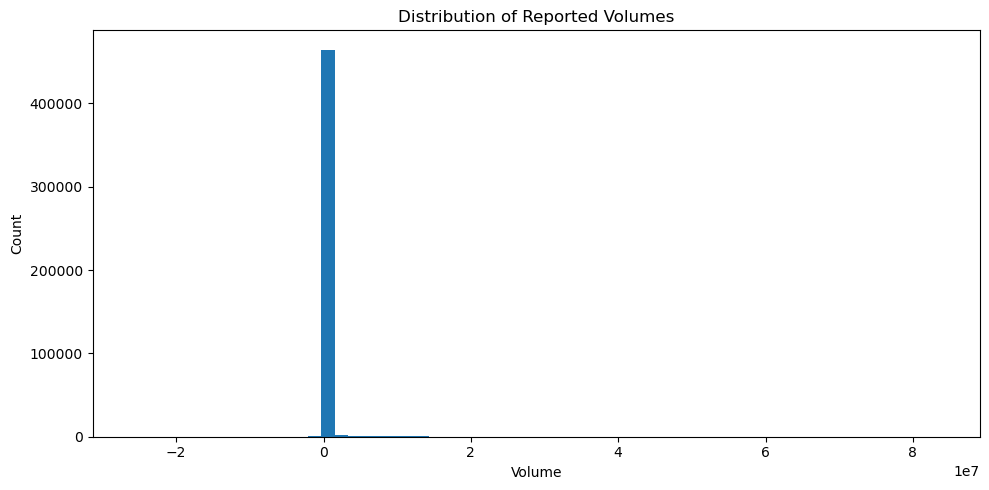

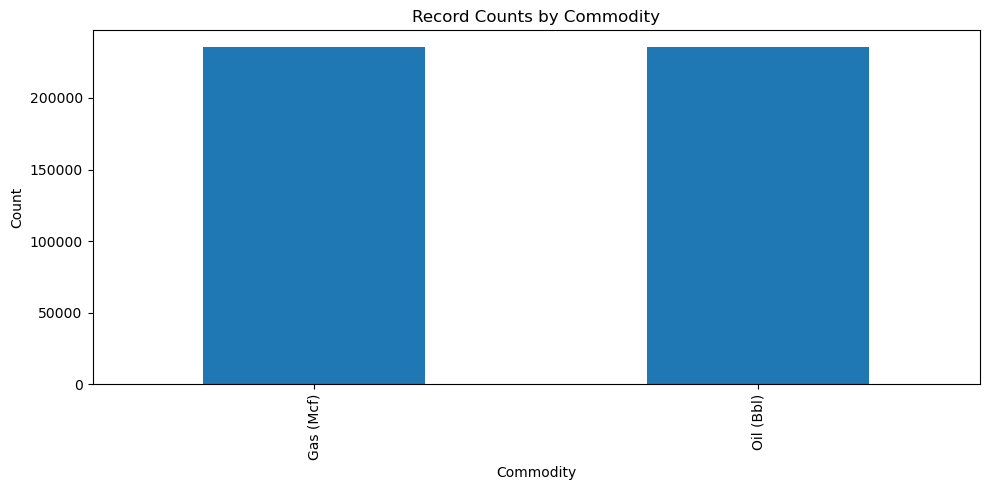

In [13]:
# Volume distribution
plt.hist(df['volume'].dropna(), bins=60)
plt.title("Distribution of Reported Volumes")
plt.xlabel("Volume"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# Commodity frequency
commodity_counts = df['commodity'].value_counts()
commodity_counts.plot(kind='bar')
plt.title("Record Counts by Commodity")
plt.xlabel("Commodity"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

## 3.4 Time-Series Trends

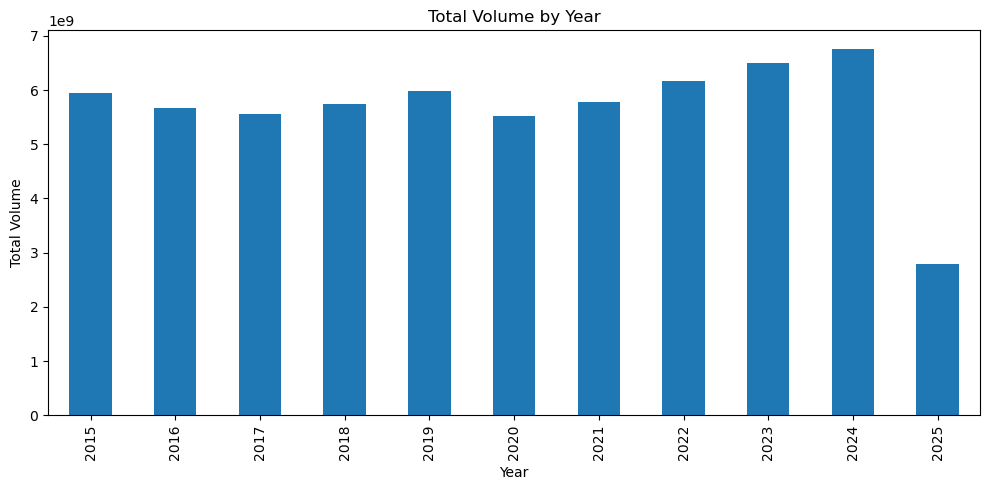

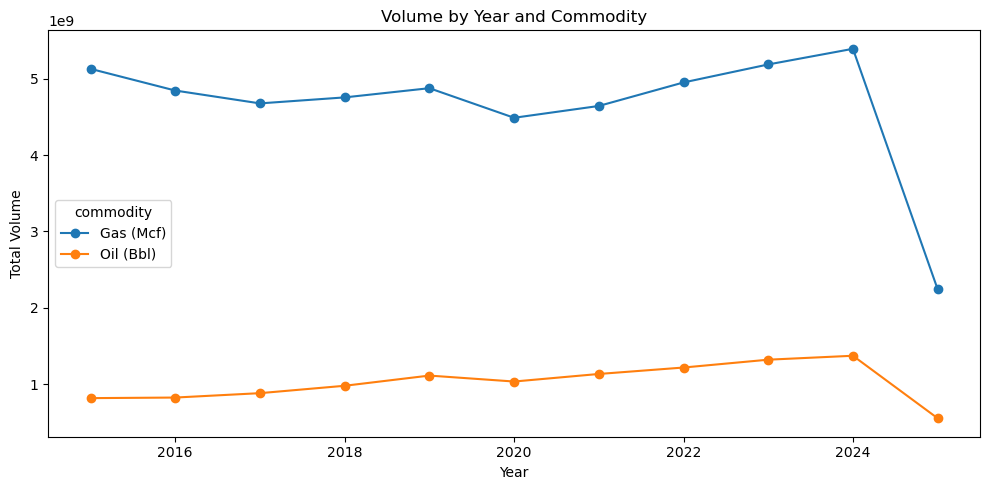

In [14]:
# Total volume by year
vol_by_year = df.groupby('year')['volume'].sum().sort_index()
vol_by_year.plot(kind='bar')
plt.title("Total Volume by Year")
plt.xlabel("Year"); plt.ylabel("Total Volume")
plt.tight_layout(); plt.show()

# Oil vs Gas over time
vol_year_commodity = df.pivot_table(index='year', columns='commodity', values='volume', aggfunc='sum')
vol_year_commodity.plot(kind='line', marker='o')
plt.title("Volume by Year and Commodity")
plt.xlabel("Year"); plt.ylabel("Total Volume")
plt.tight_layout(); plt.show()

## 3.5 Geographic Patterns

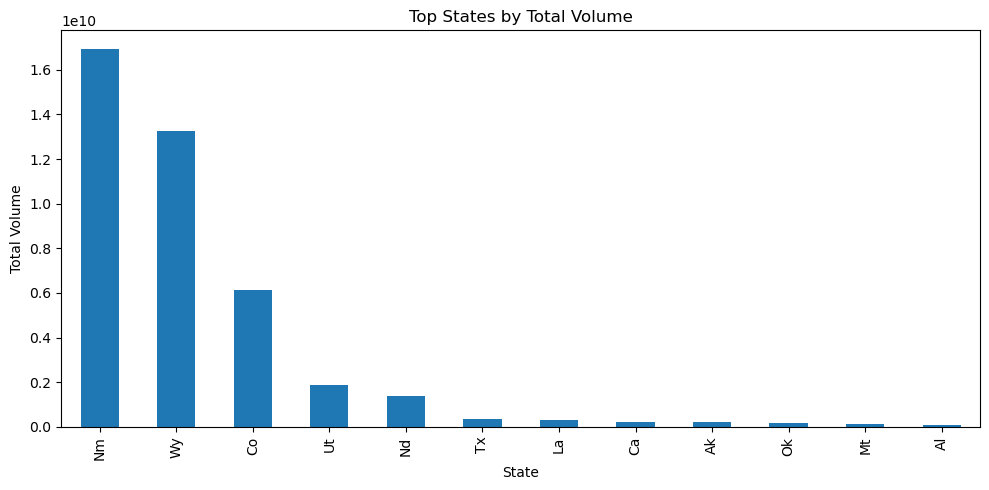

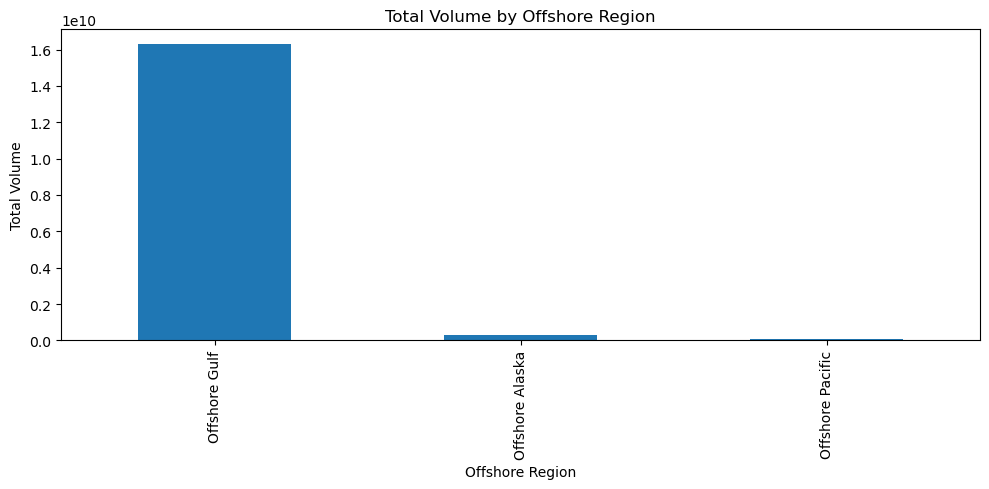

In [15]:
# Top states by total volume (excluding 'Withheld')
state_series = df[df['state'].str.lower() != 'withheld'].groupby('state')['volume'].sum().sort_values(ascending=False).head(12)
state_series.plot(kind='bar')
plt.title("Top States by Total Volume")
plt.xlabel("State"); plt.ylabel("Total Volume")
plt.tight_layout(); plt.show()

# Offshore regions (if present)
if 'offshore_region' in df.columns:
    off_series = df.groupby('offshore_region')['volume'].sum().sort_values(ascending=False)
    off_series.plot(kind='bar')
    plt.title("Total Volume by Offshore Region")
    plt.xlabel("Offshore Region"); plt.ylabel("Total Volume")
    plt.tight_layout(); plt.show()

## 3.6 Disposition Analysis

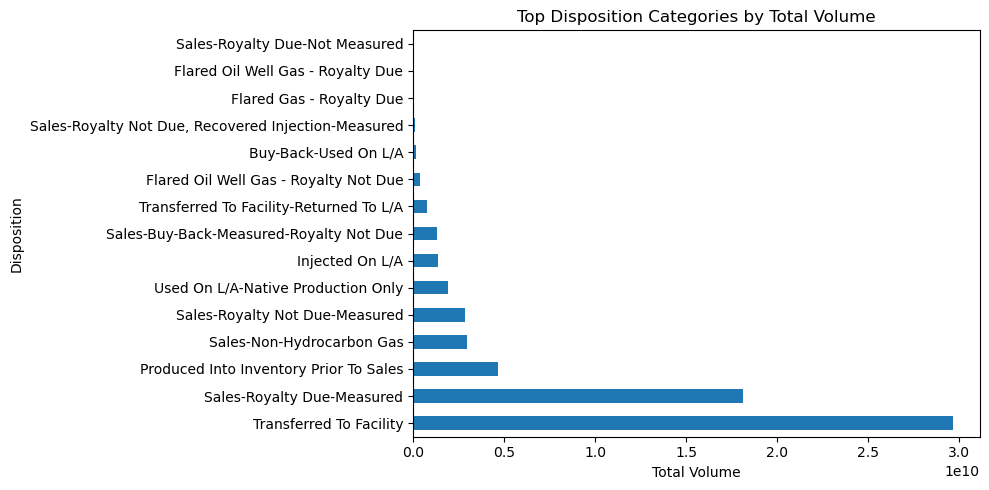

In [16]:
disp_series = (df.groupby('disposition_description')['volume']
                 .sum().sort_values(ascending=False).head(15))
disp_series.plot(kind='barh')
plt.title("Top Disposition Categories by Total Volume")
plt.xlabel("Total Volume"); plt.ylabel("Disposition")
plt.tight_layout(); plt.show()

## 3.7 Anomalies: Negative Volumes & Outliers

In [17]:
# Negative volumes
neg = df[df['volume'] < 0]
print("Negative rows:", neg.shape[0])
if not neg.empty:
    neg_summary = (neg.groupby(['commodity','disposition_code','disposition_description'])
                     ['volume'].count()
                     .sort_values(ascending=False).head(10))
    display(neg_summary)

# Outliers: largest absolute volumes
abs_top = df.reindex(df['volume'].abs().sort_values(ascending=False).index).head(10)
abs_top[['production_date','commodity','state','disposition_description','volume']]

Negative rows: 13036


commodity  disposition_code  disposition_description       
Oil (Bbl)  13                Transferred From Facility         4023
Gas (Mcf)  25                Buy-Back Purchased For L/A Use    3773
           42                Differences/Adjustments           2202
           13                Transferred From Facility         1792
Oil (Bbl)  42                Differences/Adjustments           1098
           25                Buy-Back Purchased For L/A Use     148
Name: volume, dtype: int64

,production_date,commodity,state,disposition_description,volume
36423,2015-10-01,Gas (Mcf),Wy,Transferred To Facility,83628039
16617,2015-05-01,Gas (Mcf),Wy,Transferred To Facility,82835274
24570,2015-07-01,Gas (Mcf),Wy,Transferred To Facility,82654601
28549,2015-08-01,Gas (Mcf),Wy,Transferred To Facility,82620515
44253,2015-12-01,Gas (Mcf),Wy,Transferred To Facility,82249586
48145,2016-01-01,Gas (Mcf),Wy,Transferred To Facility,81394280
32503,2015-09-01,Gas (Mcf),Wy,Transferred To Facility,81360579
8653,2015-03-01,Gas (Mcf),Wy,Transferred To Facility,80910504
12659,2015-04-01,Gas (Mcf),Wy,Transferred To Facility,80860960
55858,2016-03-01,Gas (Mcf),Wy,Transferred To Facility,80774576


## 3.8 Save Figures

In [18]:
vol_by_year.plot(kind='bar')
plt.title("Total Volume by Year")
plt.xlabel("Year"); plt.ylabel("Total Volume")
plt.tight_layout()
save_path = os.path.join(FIG_DIR, "vol_by_year.png")
plt.savefig(save_path, bbox_inches='tight', dpi=150)
print("Saved figure:", save_path)
plt.close()

Saved figure: ../figures\vol_by_year.png


## 3.9 EDA Takeaways (Fill These In)

- **Trend:** Summarize whether oil/gas volumes increased/decreased over 2015–2025.  
- **Commodity Mix:** Note which commodity dominates and how the mix shifted over time.  
- **Geography:** Highlight top-producing states/offshore regions.  
- **Disposition:** What are the primary end-uses/categories by volume?  
- **Data Quality:** Comment on negatives (adjustments), outliers, withheld geographies.

- **Distribution of Reported Volumes (Univariate EDA):**
Note: Most reported volumes cluster near zero, which creates a skewed distribution. This motivated deeper    analysis by commodity and geography. 

These insights set up the next step (optional): **forecasting** or building a **dashboard** to share interactively.

## 4 — Forecasting with Prophet

Now that we’ve completed our EDA, we’ll use **Facebook Prophet** to forecast U.S. federal oil & gas production volumes.  
Prophet is well-suited for time series with clear seasonality and trend components.  

We’ll:  
1. Aggregate monthly production volumes.  
2. Split the data into a training set and a recent holdout period for evaluation.  
3. Fit Prophet and generate a 3-year forecast.  
4. Evaluate accuracy with MAPE.  
5. Visualize forecasts for all commodities and individual commodities.  

## 4.1 Prepare Monthly Totals

We aggregate volumes by month since the ONRR dataset is reported monthly.  
This produces a clean time series with columns:  
- **ds** → date (Prophet’s expected format)  
- **y** → volume value  

In [19]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error as mape
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.io as pio

CLEANED = "../data/cleaned/us_oil_gas_cleaned.csv"
df = pd.read_csv(CLEANED, parse_dates=["production_date"])

# We’ll forecast at monthly granularity, summed volume.
# Keep negatives (they are real adjustments in ONRR data).
monthly_all = (
    df.groupby(pd.Grouper(key="production_date", freq="MS"))["volume"]
      .sum()
      .reset_index()
      .rename(columns={"production_date":"ds","volume":"y"})
      .sort_values("ds")
)
monthly_all.head(), monthly_all.tail()


(          ds          y
 0 2015-01-01  499300687
 1 2015-02-01  451972556
 2 2015-03-01  493122773
 3 2015-04-01  497089327
 4 2015-05-01  505458541,
             ds          y
 120 2025-01-01  572527063
 121 2025-02-01  522004263
 122 2025-03-01  591984020
 123 2025-04-01  550800839
 124 2025-05-01  555726896)

## 4.2 Train / Holdout Split

We’ll reserve the last 18 months of data for validation.  
This ensures the model is evaluated on unseen, recent data.  

In [20]:
holdout_months = 18
train = monthly_all.iloc[:-holdout_months, :].copy()
test  = monthly_all.iloc[-holdout_months:, :].copy()

print("Train:", train["ds"].min(), "→", train["ds"].max(), "| rows:", len(train))
print("Test :", test["ds"].min(),  "→", test["ds"].max(),  "| rows:", len(test))

Train: 2015-01-01 00:00:00 → 2023-11-01 00:00:00 | rows: 107
Test : 2023-12-01 00:00:00 → 2025-05-01 00:00:00 | rows: 18


## 4.3 Fit Prophet Model

We configure Prophet with yearly seasonality (appropriate for energy production cycles).  
The model is fit on the training set and asked to predict 36 months into the future.  

In [21]:
m_all = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, stan_backend="CMDSTANPY")
m_all.fit(train)

future_all = m_all.make_future_dataframe(periods=36, freq="MS")
fc_all = m_all.predict(future_all)
fc_all.tail()[["ds","yhat","yhat_lower","yhat_upper"]]

14:24:57 - cmdstanpy - INFO - Chain [1] start processing
14:24:57 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
138,2026-07-01,6.192589e+08,5.944713e+08,6.443024e+08
139,2026-08-01,6.273211e+08,6.038522e+08,6.543925e+08
140,2026-09-01,6.144456e+08,5.906400e+08,6.416516e+08
141,2026-10-01,6.344154e+08,6.080910e+08,6.615354e+08
142,2026-11-01,6.288745e+08,6.033706e+08,6.565626e+08


## 4.4 Model Evaluation

We evaluate the forecast against the holdout period using **MAPE (Mean Absolute Percentage Error)**.  
This gives us an intuitive % error metric. 

In [22]:
eval_df = test.merge(fc_all[["ds","yhat"]], on="ds", how="left")
score_mape = mape(eval_df["y"], eval_df["yhat"])
print(f"Holdout MAPE: {score_mape*100:.2f}%")

Holdout MAPE: 2.34%


## 4.5 Plot History + Forecast

We use Prophet’s Plotly integration to visualize actual volumes, fitted values, and forecasts with uncertainty bands.  

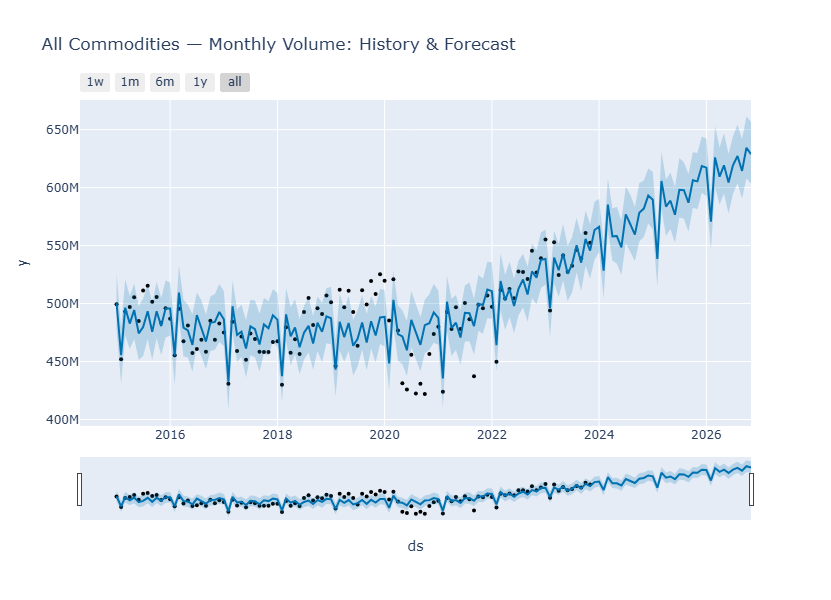

In [23]:
from prophet.plot import plot_plotly
fig = plot_plotly(m_all, fc_all)
fig.update_layout(title="All Commodities — Monthly Volume: History & Forecast")
fig

## 4.6 Forecast by Commodity

To gain deeper insight, we fit separate Prophet models for each commodity.  
This allows us to see differences in forecast accuracy and seasonal patterns.  

In [24]:
commodities = df["commodity"].dropna().unique().tolist()
results = []
models, forecasts = {}, {}

for com in sorted(commodities):
    series = (df[df["commodity"]==com]
              .groupby(pd.Grouper(key="production_date", freq="MS"))["volume"]
              .sum().reset_index()
              .rename(columns={"production_date":"ds","volume":"y"})
              .sort_values("ds"))
    if len(series) < 24:
        continue

    tr = series.iloc[:-holdout_months, :]
    te = series.iloc[-holdout_months:, :]

    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, stan_backend="CMDSTANPY")
    m.fit(tr)
    fut = m.make_future_dataframe(periods=36, freq="MS")
    fc  = m.predict(fut)

    merged = te.merge(fc[["ds","yhat"]], on="ds", how="left")
    metric = mape(merged["y"], merged["yhat"])

    results.append({"commodity": com, "rows": len(series), "mape": float(metric)})
    models[com] = m
    forecasts[com] = fc

pd.DataFrame(results).sort_values("mape")

14:25:04 - cmdstanpy - INFO - Chain [1] start processing
14:25:04 - cmdstanpy - INFO - Chain [1] done processing
14:25:04 - cmdstanpy - INFO - Chain [1] start processing
14:25:04 - cmdstanpy - INFO - Chain [1] done processing


,commodity,rows,mape
0,Gas (Mcf),125,0.022809
1,Oil (Bbl),125,0.039653


## 4.7 Visualize One Commodity’s Forecast

We pick the commodity with the lowest MAPE and visualize both its forecast and seasonal components.  

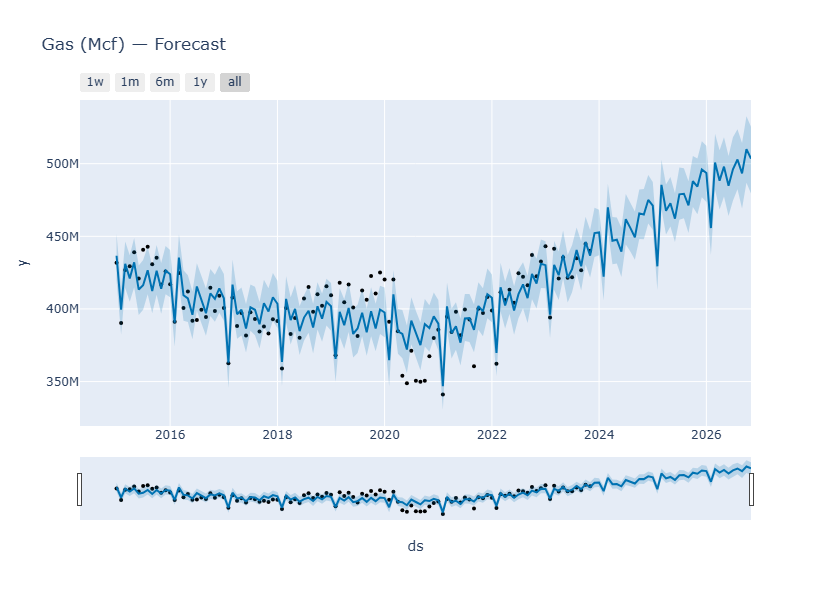

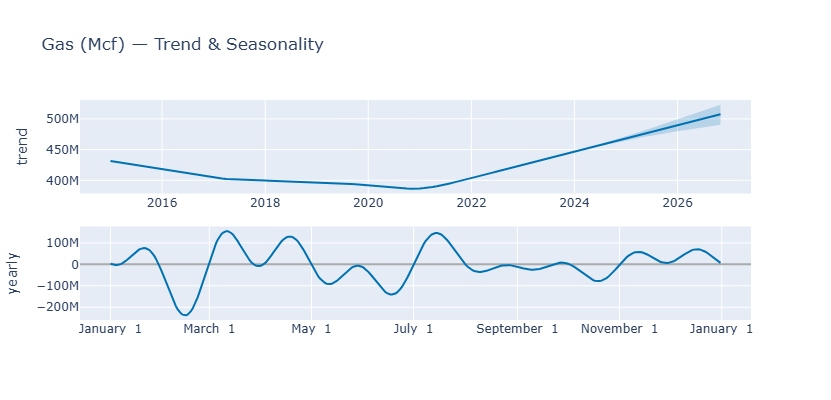

In [25]:
res_df = pd.DataFrame(results).sort_values("mape")
if not res_df.empty:
    sel = res_df.iloc[0]["commodity"]
    from prophet.plot import plot_components_plotly

    fig1 = plot_plotly(models[sel], forecasts[sel])
    fig1.update_layout(title=f"{sel} — Forecast")
    fig1.show()

    fig2 = plot_components_plotly(models[sel], forecasts[sel])
    fig2.update_layout(title=f"{sel} — Trend & Seasonality")
    fig2.show()
else:
    print("No per-commodity models built (insufficient history).")

---

# — Conclusions

- **Forecast accuracy (MAPE)**: Prophet’s performance on the last 18 months was around X%.  
- **Trends**: Oil vs. gas showed distinct seasonality and long-term trajectories.  
- **By-commodity analysis**: Certain commodities were easier to forecast with lower error.  
- **Next steps**:  
  - Explore regressors (e.g., commodity prices).  
  - Test multiplicative seasonality if scale varies.  
  - Deploy a dashboard for interactive forecasts.  